# Plot abrupt CO2 anomalies and fit different linear responses

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
import random as rd
from lmfit import Model
from scipy import optimize
plt.rcParams.update({'figure.max_open_warning': 0})
import importlib
from estimation import *
import xarray as xr


In [2]:
exp = 'abrupt2x'
model = 'CESM104'

directory = '../longrunmip_data/'
ds_tas =  xr.open_dataset(directory + 'tas_CESM104_abrupt2x_2500_anom.nc')
ds_toarad = xr.open_dataset(directory + 'netTOA_CESM104_abrupt2x_2500_anom.nc')
deltaT0 =  np.concatenate([[0],ds_tas.tas.values])

In [148]:
exp = 'abrupt4x'
model = 'CESM104'

directory = '../longrunmip_data/'
ds_tas =  xr.open_dataset(directory + 'tas_CESM104_abrupt4x_5300_anom.nc')
ds_toarad = xr.open_dataset(directory + 'netTOA_CESM104_abrupt4x_5300_anom.nc')
deltaT0 =  np.concatenate([[0],ds_tas.tas.values])


In [153]:
exp = 'abrupt8x'
model = 'CESM104'

directory = '../longrunmip_data/'
ds_tas =  xr.open_dataset(directory + 'tas_CESM104_abrupt8x_4000_anom.nc')
ds_toarad = xr.open_dataset(directory + 'netTOA_CESM104_abrupt8x_4000_anom.nc')
deltaT0 =  np.concatenate([[0],ds_tas.tas.values])


## Define linear temperature models

In [3]:
def exp_part1(t, S1, tau1):
    return S1*(1 - np.exp(-t/tau1))
def exp_part2(t, S2, tau2):
    return S2*(1 - np.exp(-t/tau2))
def exp_part3(t, S3, tau3):
    return S3*(1 - np.exp(-t/tau3))
def osc_parts(t, Sosc1, Sosc2, taup, Tq):
    p = -1/taup; q = 2*np.pi/Tq
    osc_part1 = Sosc1*(1 - np.exp(-t/taup)*(np.cos(q*t) + p/q*np.sin(q*t)))
    osc_part2 = Sosc2*(1 - np.exp(-t/taup)*(np.cos(q*t) - q/p*np.sin(q*t)))
    return osc_part1 + osc_part2

def twoexp_model(t, S1, S2, tau1, tau2):
    return exp_part1(t, S1, tau1) + exp_part2(t, S2, tau2)
def threeexp_model(t, S1, S2, S3, tau1, tau2, tau3):
    return exp_part1(t, S1, tau1) + exp_part2(t, S2, tau2) + exp_part3(t, S3, tau3)
def oscillatory_model(t, S1, S2, Sosc1, Sosc2, tau1, tau2, taup, Tq):
    return exp_part1(t, S1, tau1) + exp_part2(t, S2, tau2) + osc_parts(t, Sosc1, Sosc2, taup, Tq)

exp_model1 = Model(exp_part1); exp_model2 = Model(exp_part2); 
twoexp_model = Model(twoexp_model);
twoexp_model.set_param_hint('S1', value=4, min=0, max=10.0)
twoexp_model.set_param_hint('S2', value=2, min=0, max=10.0)
twoexp_model.set_param_hint('tau1', value=4, min=0, max=8)
twoexp_model.set_param_hint('tau2', value=20, min=8, max=1000)

exp_model3 = Model(exp_part3); threeexp_model = Model(threeexp_model);
threeexp_model.set_param_hint('S1', value=4, min=0, max=10.0)
threeexp_model.set_param_hint('S2', value=2, min=0, max=10.0)
threeexp_model.set_param_hint('S3', value=2, min=0, max=10.0)
threeexp_model.set_param_hint('tau1', value=4, min=0, max=8)
threeexp_model.set_param_hint('tau2', value=20, min=8, max=100)
threeexp_model.set_param_hint('tau3', value=200, min=100, max=1000)

osc_model = Model(osc_parts); expandosc_model = Model(oscillatory_model)
expandosc_model.set_param_hint('S1', value=4, min=0, max=10.0)# guess the same as for two-box model 
expandosc_model.set_param_hint('S2', value=2, min=0, max=10.0)
expandosc_model.set_param_hint('Sosc1', value=0.5, min=0, max=4.0)
expandosc_model.set_param_hint('Sosc2', value=0.5, min=0, max=4.0)
expandosc_model.set_param_hint('tau1', value=4, min=0, max=8)
expandosc_model.set_param_hint('tau2', value=20, min=8, max=1000)

In [4]:
ds_toarad['netTOA'].values

array([2.405662 , 2.7744212, 2.5563037, ...,       nan,       nan,
             nan], dtype=float32)

In [4]:
deltaN = ds_toarad['netTOA'].values
deltaN = deltaN[np.isnan(deltaN)==False]
deltaT0 = deltaT0[np.isnan(deltaT0)==False]
deltaN

array([2.405662  , 2.7744212 , 2.5563037 , ..., 0.21904573, 0.1015249 ,
       0.40560704], dtype=float32)

[6.639764528667384, 638.9702831726903, 619.0062180366428, 409.6513992544387]
1


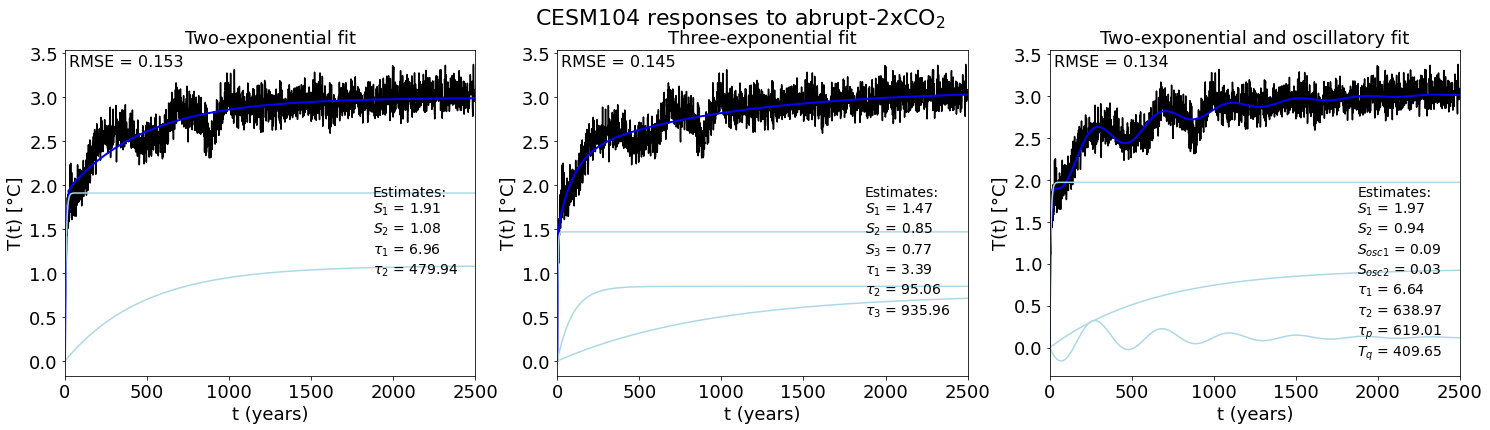

In [5]:

years = np.arange(1,len(deltaN)+1)
years0 = np.concatenate(([0],years))

fig, ax = plt.subplots(ncols = 3, figsize = [25,6]);
fig.suptitle(model + ' responses to abrupt-2xCO$_2$',fontsize = 22)
for axis in ax:
    axis.set_xlabel('t (years)',fontsize = 18)
    axis.set_ylabel('T(t) [°C]',fontsize = 18)
    axis.set_xlim(min(years0),max(years0))
    axis.tick_params(axis='both',labelsize=18)
    axis.plot(years0, deltaT0, color = 'black')

# plot results of two-exp fit
result_twoexp = twoexp_model.fit(deltaT0, t=years0)
twoexp_rms = np.sqrt(np.mean(result_twoexp.residual**2))
#print(result_twoexp.fit_report())
ax[0].plot(years0, result_twoexp.best_fit, '-', label='best fit', color = 'blue', linewidth = 2)
ax[0].plot(years0, exp_model1.eval(result_twoexp.params, t=years0), color = 'lightblue')
ax[0].plot(years0, exp_model2.eval(result_twoexp.params, t=years0), color = 'lightblue')
ax[0].set_title('Two-exponential fit', fontsize = 18)
ax[0].text(0.01, 0.95, 'RMSE = ' + str(np.round(twoexp_rms,3)), transform=ax[0].transAxes, fontsize = 16)
partoshow = ['S1', 'S2', 'tau1', 'tau2']
estimates = [result_twoexp.best_values[par] for par in partoshow]
textlabels = ['$S_1$', '$S_2$', r'$\tau_1$', r'$\tau_2$']
ax[0].text(0.75,0.55, 'Estimates:', fontsize=14, transform=ax[0].transAxes)
for (ind, estimate) in enumerate(estimates):
    ax[0].text(0.75,0.5*(1-ind/8),textlabels[ind] + ' = ' + str('{:.2f}'.format(np.round(estimate,2))), fontsize=14, transform=ax[0].transAxes)



# plot results of three-exp fit
result_threeexp = threeexp_model.fit(deltaT0, t=years0)
threeexp_rms = np.sqrt(np.mean(result_threeexp.residual**2))
ax[1].plot(years0, result_threeexp.best_fit, '-', label='best fit', color = 'blue', linewidth = 2)
ax[1].plot(years0, exp_model1.eval(result_threeexp.params, t=years0), color = 'lightblue')
ax[1].plot(years0, exp_model2.eval(result_threeexp.params, t=years0), color = 'lightblue')
ax[1].plot(years0, exp_model3.eval(result_threeexp.params, t=years0), color = 'lightblue')
ax[1].set_title('Three-exponential fit', fontsize = 18)
ax[1].text(0.01, 0.95, 'RMSE = ' + str(np.round(threeexp_rms,3)), transform=ax[1].transAxes, fontsize = 16)

partoshow = ['S1', 'S2', 'S3', 'tau1', 'tau2', 'tau3']
estimates = [result_threeexp.best_values[par] for par in partoshow]
textlabels = ['$S_1$', '$S_2$', '$S_3$', r'$\tau_1$', r'$\tau_2$', r'$\tau_3$']
ax[1].text(0.75,0.55, 'Estimates:', fontsize=14, transform=ax[1].transAxes)
for (ind, estimate) in enumerate(estimates):
    ax[1].text(0.75,0.5*(1-ind/8),textlabels[ind] + ' = ' + str('{:.2f}'.format(np.round(estimate,2))), fontsize=14, transform=ax[1].transAxes)


# plot results of three-exp fit
expandosc_model.set_param_hint('taup', value=600, min=20, max=1000)
expandosc_model.set_param_hint('Tq', value=100, min=40, max=2000)
result_expandosc = expandosc_model.fit(deltaT0, t=years0)
expandosc_rms = np.sqrt(np.mean(result_expandosc.residual**2))
i=0; #expandosc_rms = 1
while expandosc_rms > twoexp_rms: # make new guess
    taup_guess = 10**rd.uniform(np.log10(20), np.log10(1000))
    Tq_guess = 10**rd.uniform(np.log10(40), np.log10(2000))
    expandosc_model.set_param_hint('taup', value=taup_guess, min=20, max=1000)
    expandosc_model.set_param_hint('Tq', value=Tq_guess, min=40, max=2000)
    result_expandosc = expandosc_model.fit(deltaT0, t=years0)
    expandosc_rms = np.sqrt(np.mean(result_expandosc.residual**2))
    partoshow = ['tau1', 'tau2', 'taup', 'Tq']
    estimates = [result_expandosc.best_values[par] for par in partoshow]
    if expandosc_rms < 0.2:
        #ax[2].plot(years0, result_expandosc.best_fit, '-', label='best fit', color = 'blue', linewidth = 2)
        print(estimates)
    i =+ 1; print(i)

ax[2].plot(years0, result_expandosc.best_fit, '-', label='best fit', color = 'blue', linewidth = 2)
ax[2].plot(years0, exp_model1.eval(result_expandosc.params, t=years0), color = 'lightblue')
ax[2].plot(years0, exp_model2.eval(result_expandosc.params, t=years0), color = 'lightblue')
ax[2].plot(years0, osc_model.eval(result_expandosc.params, t=years0), color = 'lightblue')
ax[2].set_title('Two-exponential and oscillatory fit', fontsize = 18)
ax[2].text(0.01, 0.95, 'RMSE = ' + str(np.round(expandosc_rms,3)), transform=ax[2].transAxes, fontsize = 16)

partoshow = ['S1', 'S2', 'Sosc1', 'Sosc2', 'tau1', 'tau2', 'taup', 'Tq']
estimates = [result_expandosc.best_values[par] for par in partoshow]
textlabels = ['$S_1$', '$S_2$', '$S_{osc1}$', '$S_{osc2}$', r'$\tau_1$', r'$\tau_2$', r'$\tau_p$', r'$T_q$']
ax[2].text(0.75,0.55, 'Estimates:', fontsize=14, transform=ax[2].transAxes)
for (ind, estimate) in enumerate(estimates):
    ax[2].text(0.75,0.5*(1-ind/8),textlabels[ind] + ' = ' + str('{:.2f}'.format(np.round(estimate,2))), fontsize=14, transform=ax[2].transAxes)

#plt.savefig('../Figures/' + model + '_' + exp + '_linresponses_comparison.pdf', format='pdf', dpi=600, bbox_inches="tight")

# With linearly increasing forcing to 140 years:

In [6]:
# define a forcing:
def linear_to140years(max_t = 150): # forcing that increases linearly to 1 for the first 140 years, thereafter it remains constant
    forcing_first140 = np.arange(0,141)/140 # including year 0 in array
    forcing_constant = np.tile(1, max_t-140)
    return np.concatenate([forcing_first140, forcing_constant])


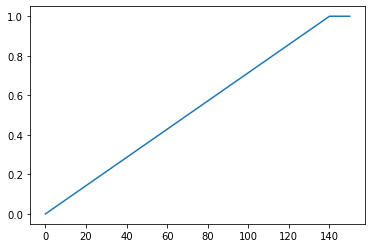

In [7]:
plt.plot(linear_to140years(max_t = 150))

In [8]:
parameters = ['S1', 'S2', 'Sosc1', 'Sosc2', 'tau1', 'tau2', 'taup', 'Tq']
estimates
par_values = {}
for (i,par) in enumerate(parameters):
    par_values[par] = estimates[i]

In [9]:
def osc_part1(t, Sosc1, taup, Tq):
    p = -1/taup; q = 2*np.pi/Tq
    osc_part1 = Sosc1*(1 - np.exp(-t/taup)*(np.cos(q*t) + p/q*np.sin(q*t)))
    return osc_part1

def osc_part2(t, Sosc2, taup, Tq):
    p = -1/taup; q = 2*np.pi/Tq
    osc_part2 = Sosc2*(1 - np.exp(-t/taup)*(np.cos(q*t) - q/p*np.sin(q*t)))
    return osc_part2

In [10]:
def osc_parts(t, Sosc1, Sosc2, taup, Tq):
    p = -1/taup; q = 2*np.pi/Tq
    osc_part1 = Sosc1*(1 - np.exp(-t/taup)*(np.cos(q*t) + p/q*np.sin(q*t)))
    osc_part2 = Sosc2*(1 - np.exp(-t/taup)*(np.cos(q*t) - q/p*np.sin(q*t)))
    return osc_part1 + osc_part2

In [11]:

def exp_part1_fixedpar(t, par_values):
    return exp_part1(t, S1 = par_values['S1'], tau1 = par_values['tau1'])
def exp_part2_fixedpar(t, par_values):
    return exp_part2(t, S2 = par_values['S2'], tau2 = par_values['tau2'])
def osc_parts_fixedpar(t, par_values):
    return osc_parts(t, Sosc1 = par_values['Sosc1'], Sosc2 = par_values['Sosc2'], taup = par_values['taup'], Tq = par_values['Tq'])
def osc_part1_fixedpar(t, par_values):
    return osc_part1(t, Sosc1 = par_values['Sosc1'], taup = par_values['taup'], Tq = par_values['Tq'])
def osc_part2_fixedpar(t, par_values):
    return osc_part2(t, Sosc2 = par_values['Sosc2'], taup = par_values['taup'], Tq = par_values['Tq'])

def oscillatory_model_fixedpar(t, par_values):
    return exp_part1_fixedpar(t, par_values) + exp_part2_fixedpar(t, par_values) + osc_parts_fixedpar(t, par_values)

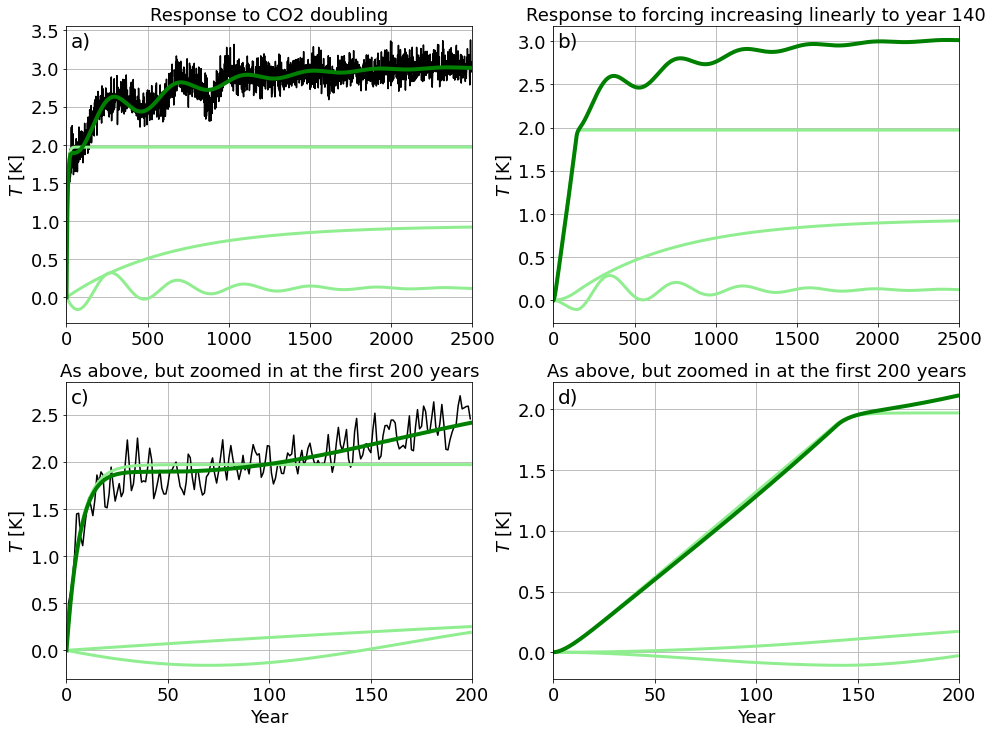

In [22]:
# check that functions work:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = [16,6*2]);
comp_width = 3; sum_width = 4
max_t = 2500
ax[0,0].plot(years0, deltaT0, color = 'black')
ax[0,0].plot(exp_part1_fixedpar(np.arange(max_t), par_values), color = 'lightgreen', linewidth = comp_width)
ax[0,0].plot(exp_part2_fixedpar(np.arange(max_t), par_values), color = 'lightgreen', linewidth = comp_width)
ax[0,0].plot(osc_parts_fixedpar(np.arange(max_t), par_values), color = 'lightgreen', linewidth = comp_width)
ax[0,0].plot(oscillatory_model_fixedpar(np.arange(max_t), par_values), color = 'green', linewidth = sum_width)
ax[0,0].set_title('Response to CO2 doubling', fontsize = 18)
ax[0,0].grid()
ax[0,0].set_xlim(0,max_t)
ax[0,0].tick_params(axis='both',labelsize=18)
ax[0,0].set_ylabel('$T$ [K]', fontsize = 18)
ax[0,0].text(0.01, 0.93, 'a)', transform=ax[0,0].transAxes, fontsize = 20)

max_t = 2500
ax[0,1].plot(np.convolve(linear_to140years(max_t = max_t), np.diff(exp_part1_fixedpar(np.arange(max_t), par_values)), mode = 'full')[:max_t], color = 'lightgreen', linewidth = comp_width)
ax[0,1].plot(np.convolve(linear_to140years(max_t = max_t), np.diff(exp_part2_fixedpar(np.arange(max_t), par_values)), mode = 'full')[:max_t], color = 'lightgreen', linewidth = comp_width)
ax[0,1].plot(np.convolve(linear_to140years(max_t = max_t), np.diff(osc_parts_fixedpar(np.arange(max_t), par_values)), mode = 'full')[:max_t], color = 'lightgreen', linewidth = comp_width)
ax[0,1].plot(np.convolve(linear_to140years(max_t = max_t), np.diff(oscillatory_model_fixedpar(np.arange(0,max_t), par_values = par_values)), mode = 'full')[:max_t], color = 'green', linewidth = sum_width)
ax[0,1].set_title('Response to forcing increasing linearly to year 140', fontsize = 18)
ax[0,1].grid()
ax[0,1].set_xlim(0,max_t)
ax[0,1].tick_params(axis='both',labelsize=18)
ax[0,1].set_ylabel('$T$ [K]', fontsize = 18)
ax[0,1].text(0.01, 0.93, 'b)', transform=ax[0,1].transAxes, fontsize = 20)

max_t = 200
ax[1,0].plot(years0[:max_t], deltaT0[:max_t], color = 'black')
ax[1,0].plot(exp_part1_fixedpar(np.arange(max_t), par_values), color = 'lightgreen', linewidth = comp_width)
ax[1,0].plot(exp_part2_fixedpar(np.arange(max_t), par_values), color = 'lightgreen', linewidth = comp_width)
ax[1,0].plot(osc_parts_fixedpar(np.arange(max_t), par_values), color = 'lightgreen', linewidth = comp_width)
ax[1,0].plot(oscillatory_model_fixedpar(np.arange(max_t), par_values), color = 'green', linewidth = sum_width)
ax[1,0].set_title('As above, but zoomed in at the first 200 years', fontsize = 18)
ax[1,0].grid()
ax[1,0].set_xlim(0,max_t)
ax[1,0].tick_params(axis='both',labelsize=18)
ax[1,0].set_ylabel('$T$ [K]', fontsize = 18);  ax[1,0].set_xlabel('Year', fontsize = 18);
ax[1,0].text(0.01, 0.93, 'c)', transform=ax[1,0].transAxes, fontsize = 20)

#max_t = 200
ax[1,1].plot(np.convolve(linear_to140years(max_t = max_t), np.diff(exp_part1_fixedpar(np.arange(max_t), par_values)), mode = 'full')[:max_t], color = 'lightgreen', linewidth = comp_width)
ax[1,1].plot(np.convolve(linear_to140years(max_t = max_t), np.diff(exp_part2_fixedpar(np.arange(max_t), par_values)), mode = 'full')[:max_t], color = 'lightgreen', linewidth = comp_width)
ax[1,1].plot(np.convolve(linear_to140years(max_t = max_t), np.diff(osc_parts_fixedpar(np.arange(max_t), par_values)), mode = 'full')[:max_t], color = 'lightgreen', linewidth = comp_width)
ax[1,1].plot(np.convolve(linear_to140years(max_t = max_t), np.diff(oscillatory_model_fixedpar(np.arange(0,max_t), par_values = par_values)), mode = 'full')[:max_t], color = 'green', linewidth = sum_width)
ax[1,1].set_title('As above, but zoomed in at the first 200 years', fontsize = 18)
ax[1,1].grid()
ax[1,1].set_xlim(0,max_t)
ax[1,1].tick_params(axis='both',labelsize=18)
ax[1,1].set_ylabel('$T$ [K]', fontsize = 18); ax[1,1].set_xlabel('Year', fontsize = 18);
ax[1,1].text(0.01, 0.93, 'd)', transform=ax[1,1].transAxes, fontsize = 20);


#plt.savefig('../Figures/' + model + '_' + exp + '_expandosc_responses.pdf', format='pdf', dpi=600, bbox_inches="tight")

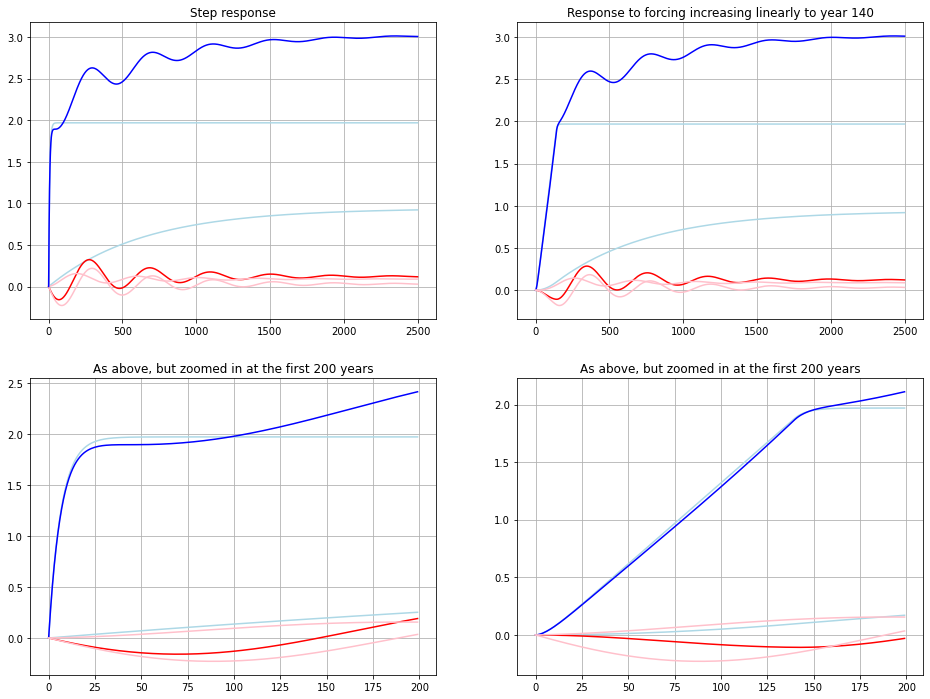

In [12]:
# check that functions work:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = [16,6*2]);
max_t = 2500
ax[0,0].plot(exp_part1_fixedpar(np.arange(max_t), par_values), color = 'lightblue')
ax[0,0].plot(exp_part2_fixedpar(np.arange(max_t), par_values), color = 'lightblue')
ax[0,0].plot(osc_parts_fixedpar(np.arange(max_t), par_values), color = 'red')
ax[0,0].plot(osc_part1_fixedpar(np.arange(max_t), par_values), color = 'pink')
ax[0,0].plot(osc_part2_fixedpar(np.arange(max_t), par_values), color = 'pink')
ax[0,0].plot(oscillatory_model_fixedpar(np.arange(max_t), par_values), color = 'blue')
ax[0,0].set_title('Step response')
ax[0,0].grid()

max_t = 2500
ax[0,1].plot(np.convolve(linear_to140years(max_t = max_t), np.diff(exp_part1_fixedpar(np.arange(max_t), par_values)), mode = 'full')[:max_t], color = 'lightblue')
ax[0,1].plot(np.convolve(linear_to140years(max_t = max_t), np.diff(exp_part2_fixedpar(np.arange(max_t), par_values)), mode = 'full')[:max_t], color = 'lightblue')
ax[0,1].plot(np.convolve(linear_to140years(max_t = max_t), np.diff(osc_parts_fixedpar(np.arange(max_t), par_values)), mode = 'full')[:max_t], color = 'red')
ax[0,1].plot(np.convolve(linear_to140years(max_t = max_t), np.diff(oscillatory_model_fixedpar(np.arange(0,max_t), par_values = par_values)), mode = 'full')[:max_t], color = 'blue')
ax[0,1].plot(np.convolve(linear_to140years(max_t = max_t), np.diff(osc_part1_fixedpar(np.arange(max_t), par_values)), mode = 'full')[:max_t], color = 'pink')
ax[0,1].plot(np.convolve(linear_to140years(max_t = max_t), np.diff(osc_part2_fixedpar(np.arange(max_t), par_values)), mode = 'full')[:max_t], color = 'pink')
ax[0,1].set_title('Response to forcing increasing linearly to year 140')
ax[0,1].grid()

max_t = 200
ax[1,0].plot(exp_part1_fixedpar(np.arange(max_t), par_values), color = 'lightblue')
ax[1,0].plot(exp_part2_fixedpar(np.arange(max_t), par_values), color = 'lightblue')
ax[1,0].plot(osc_parts_fixedpar(np.arange(max_t), par_values), color = 'red')
ax[1,0].plot(oscillatory_model_fixedpar(np.arange(max_t), par_values), color = 'blue')
ax[1,0].plot(osc_part1_fixedpar(np.arange(max_t), par_values), color = 'pink')
ax[1,0].plot(osc_part2_fixedpar(np.arange(max_t), par_values), color = 'pink')
ax[1,0].set_title('As above, but zoomed in at the first 200 years')
ax[1,0].grid()

#max_t = 200
ax[1,1].plot(np.convolve(linear_to140years(max_t = max_t), np.diff(exp_part1_fixedpar(np.arange(max_t), par_values)), mode = 'full')[:max_t], color = 'lightblue')
ax[1,1].plot(np.convolve(linear_to140years(max_t = max_t), np.diff(exp_part2_fixedpar(np.arange(max_t), par_values)), mode = 'full')[:max_t], color = 'lightblue')
ax[1,1].plot(np.convolve(linear_to140years(max_t = max_t), np.diff(osc_parts_fixedpar(np.arange(max_t), par_values)), mode = 'full')[:max_t], color = 'red')
ax[1,1].plot(np.convolve(linear_to140years(max_t = max_t), np.diff(oscillatory_model_fixedpar(np.arange(0,max_t), par_values = par_values)), mode = 'full')[:max_t], color = 'blue')
ax[1,1].plot(osc_part1_fixedpar(np.arange(max_t), par_values), color = 'pink')
ax[1,1].plot(osc_part2_fixedpar(np.arange(max_t), par_values), color = 'pink')
ax[1,1].set_title('As above, but zoomed in at the first 200 years')
ax[1,1].grid()

#plt.savefig('../Figures/' + model + '_' + exp + '_linresponses_to_linearforcing_v2.pdf', format='pdf', dpi=600, bbox_inches="tight")